## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
from tqdm.notebook import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Importing the data

In [3]:
path = os.listdir("Training/")
classes = {"no_tumor" : 0, "pituitary_tumor":1, "meningioma_tumor":2, "glioma_tumor":3}

In [4]:
x = []
y = []

for cls in classes:
    pth = "Training/"+cls
    for i in os.listdir(pth):
        img = cv2.imread(pth+"/"+i, 0)
        img = cv2.resize(img, (200,200))
        x.append(img)
        y.append(classes[cls])

In [5]:
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(2870, 200, 200)
(2870,)


In [6]:
np.unique(y)

array([0, 1, 2, 3])

In [7]:
pd.Series(y).value_counts()

1    827
3    826
2    822
0    395
Name: count, dtype: int64

In [8]:
x.shape

(2870, 200, 200)

## Visuilazation of data

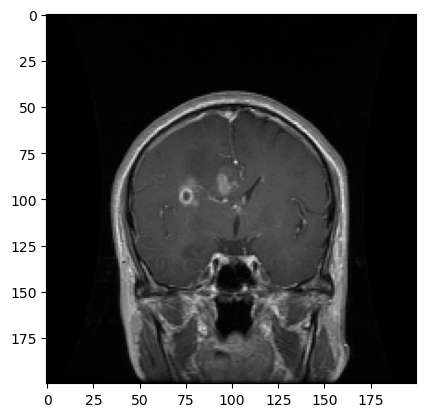

In [9]:
plt.imshow(x[2700], cmap = "gray")

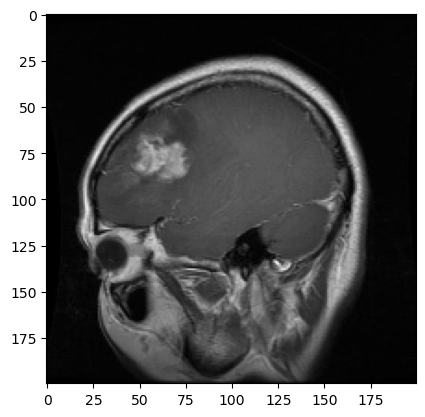

In [10]:
plt.imshow(x[2500], cmap = "gray")

# Preprocessing of the data

### Split data

In [11]:
x_update = x.reshape(len(x), -1)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_update, y, test_size = 0.2, random_state=0)

In [13]:
x_train.shape,x_test.shape

((2296, 40000), (574, 40000))

### Feature scaling

In [14]:
print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())
x_train = x_train/255
x_test=x_test/255
print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())

255 0
255 0
1.0 0.0
1.0 0.0


### Feature Selection: PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(.98,random_state=0)
pca_train = pca.fit_transform(x_train)
pca_test = pca.transform(x_test)

In [17]:
print(pca_train.shape, pca_test.shape)

(2296, 1301) (574, 1301)


## Train Model

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

def models(x, y):
    # Training of the Logistic Regression model
    log = LogisticRegression(solver='liblinear', penalty='l1',C= 1291.5496650148827, max_iter=1000, random_state=42)
    log.fit(x, y)
    
    # Training of the KNN model
    knn = KNeighborsClassifier(n_neighbors = 5, metric = "minkowski", p = 2)
    knn.fit(x, y)
    
    # Training of the Linear SVM model
    svm1 = LinearSVC(random_state = 42)
    svm1.fit(x, y)
    
    # Training of the RBF Kernel SVM model
    kernel_svm = SVC(max_iter=1000,kernel = "rbf", random_state = 42, C = 0.1)
    kernel_svm.fit(x, y)
    
    # Training of the Naive Bayes
    naive = GaussianNB()
    naive.fit(x, y)
    
    # Training of the Decision Tree model
    dtree = DecisionTreeClassifier(criterion = "gini", random_state = 42)
    dtree.fit(x, y)
    
    # Training of the Random Forest model
    rforest = RandomForestClassifier(max_depth=70, min_samples_split=4, min_samples_leaf=3, 
                                    n_estimators = 1000, criterion = "gini" ,max_features='sqrt',random_state = 42)
    rforest.fit(x, y)
    
    print('[0]Logistic Regression Training Accuracy:', log.score(x, y))
    print('[1]K Nearest Neighbor Training Accuracy:', knn.score(x, y))
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svm1.score(x, y))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', kernel_svm.score(x, y))
    print('[4]Gaussian Naive Bayes Training Accuracy:', naive.score(x, y))
    print('[5]Decision Tree Classifier Training Accuracy:', dtree.score(x, y))
    print('[6]Random Forest Classifier Training Accuracy:', rforest.score(x, y))
    
    return log, knn, svm1, kernel_svm, naive, dtree, rforest

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

model = models(pca_train, y_train)

[0]Logistic Regression Training Accuracy: 1.0
[1]K Nearest Neighbor Training Accuracy: 0.8689024390243902
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 1.0
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.7103658536585366
[4]Gaussian Naive Bayes Training Accuracy: 0.5553135888501742
[5]Decision Tree Classifier Training Accuracy: 1.0
[6]Random Forest Classifier Training Accuracy: 1.0


## Test Model

In [20]:
def plot_test_results(path,model):
    dec = {0:"No tumor", 1:"Pituitary tumor", 2: "Meningioma tumor", 3:"Glioma tumor"}
    plt.figure(figsize = (8,8))
    c = 1
    for i in os.listdir("Testing/"+path)[:9]:
        plt.subplot(3, 3, c)

        img = cv2.imread("Testing/"+path+i,0)
        img1 = cv2.resize(img, (200,200))
        img1 = img1.reshape(1, -1)/255
        p = model.predict(pca.transform(img1))
        plt.title(dec[p[0]])
        plt.imshow(img, cmap = "bone")
        plt.axis("off")
        c+=1

**Models choosen randomly**

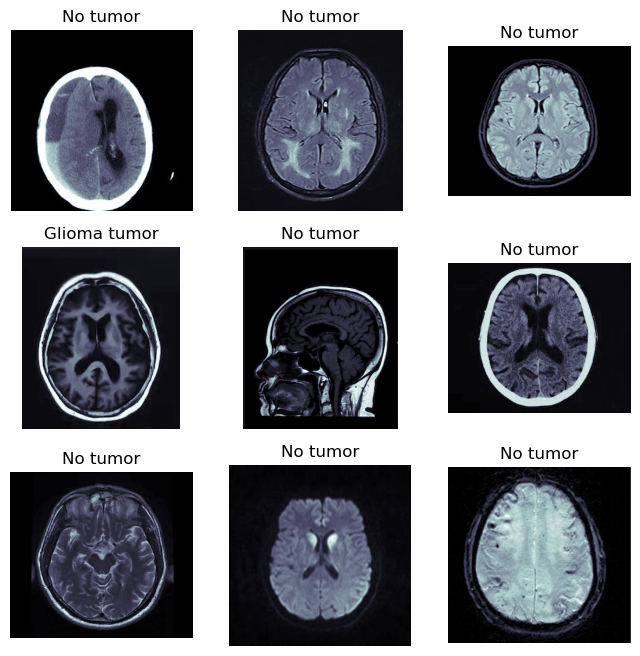

In [21]:
plot_test_results("no_tumor/", model[0])

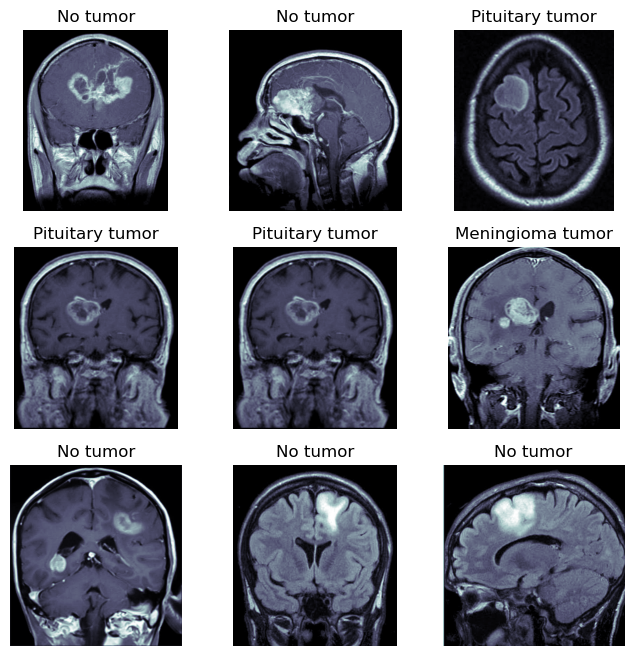

In [22]:
plot_test_results("glioma_tumor/", model[1])

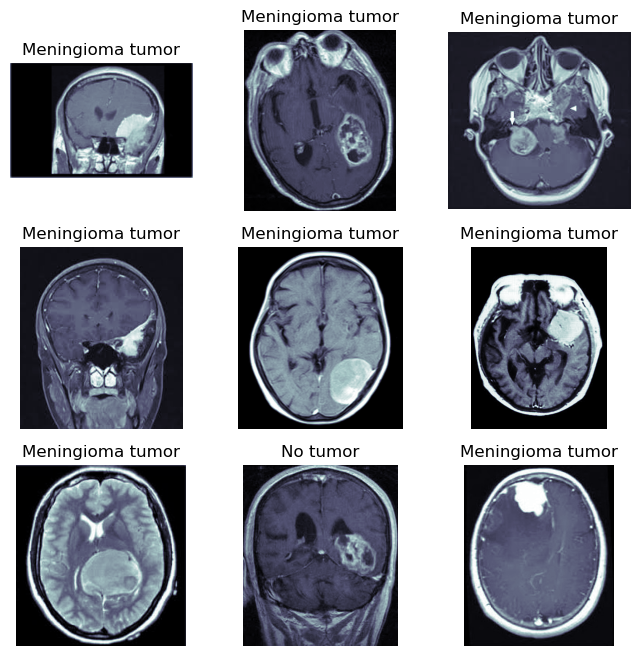

In [23]:
plot_test_results("meningioma_tumor/",model[3])

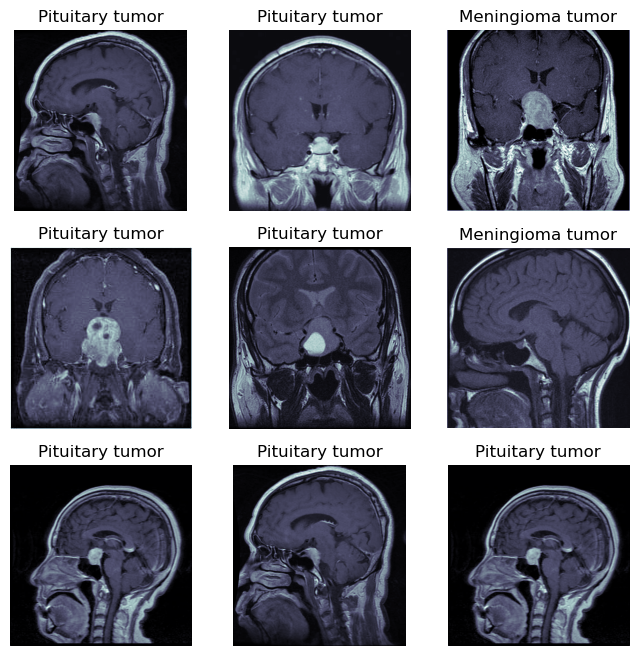

In [24]:
plot_test_results("pituitary_tumor/",model[5])

## Evaluation

In [27]:
for i in tqdm(range(len(model))):
    print(confusion_matrix(y_test, model[i].predict(pca_test)))
    print("Model[{}] Testing Accuracy".format(i),accuracy_score(y_test, model[i].predict(pca_test)))
    print("Model[{}] Testing Precision".format(i),precision_score(y_test, model[i].predict(pca_test), average='micro'))
    print("Model[{}] Testing Recall".format(i),recall_score(y_test, model[i].predict(pca_test), average='micro'))      
    print()

  0%|          | 0/7 [00:00<?, ?it/s]

[[ 50   3  17   6]
 [  2 175   2   3]
 [ 21   3  95  31]
 [  3   6  30 127]]
Model[0] Testing Accuracy 0.7787456445993032
Model[0] Testing Precision 0.7787456445993032
Model[0] Testing Recall 0.7787456445993032

[[ 56  10   4   6]
 [  2 173   4   3]
 [ 29   9  78  34]
 [  4   1  11 150]]
Model[1] Testing Accuracy 0.7961672473867596
Model[1] Testing Precision 0.7961672473867596
Model[1] Testing Recall 0.7961672473867596

[[ 50   5  15   6]
 [  2 172   5   3]
 [ 23   5  91  31]
 [  4   5  23 134]]
Model[2] Testing Accuracy 0.7787456445993032
Model[2] Testing Precision 0.7787456445993032
Model[2] Testing Recall 0.7787456445993032

[[  9  14  43  10]
 [  0 168   4  10]
 [  3  17 107  23]
 [  0  12  37 117]]
Model[3] Testing Accuracy 0.6986062717770035
Model[3] Testing Precision 0.6986062717770035
Model[3] Testing Recall 0.6986062717770035

[[ 20  29  11  16]
 [ 11  23  39 109]
 [  6  12  48  84]
 [  1   2  17 146]]
Model[4] Testing Accuracy 0.41289198606271776
Model[4] Testing Precision 0.